In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1
Import data and make some exploratory analysis. Distance is normalized to the average, Population is normalized to the total population

In [2]:
cities = pd.read_csv('cityData.dat', header=None, sep='\t', index_col=0, names=['City', 'Population', 'Latitude', 'Longitude'])
cities.head()

,City,Population,Latitude,Longitude
0,Berlin,0.170716,52.52,13.38
1,Hamburg,0.087981,53.55,10.00
2,Munich,0.067102,48.14,11.58
3,Cologne,0.050797,50.95,6.97
4,Frankfurt,0.033703,50.12,8.68


In [3]:
cities.shape

(40, 4)

In [4]:
distances = pd.read_csv('cityDistances.dat', sep='\t', header= None, names=['Origin','Destiny','Distance'])
distances.head()

,Origin,Destiny,Distance
0,0,1,5.084382
1,0,2,10.082311
2,0,3,9.523469
3,0,4,8.456714
4,0,5,10.201078


In [5]:
distances.shape

(780, 3)

### Step 1.5
Try to define a graph with the data 

In [6]:
nodes = [(i,cities.to_dict(orient='records')[i]) for i in range(cities.shape[0])]
edges = [(distances.iloc[i,0],distances.iloc[i,1],{'weight': distances.iloc[i,2]}) for i in range(distances.shape[0])]

In [7]:
print(nodes[:3])
print(edges[:3])

[(0, {'City': 'Berlin', 'Population': 0.1707159963294827, 'Latitude': 52.52, 'Longitude': 13.38}), (1, {'City': 'Hamburg', 'Population': 0.0879805435806981, 'Latitude': 53.55, 'Longitude': 10.0}), (2, {'City': 'Munich', 'Population': 0.0671020343799828, 'Latitude': 48.14, 'Longitude': 11.58})]
[(0, 1, {'weight': 5.084381891841052}), (0, 2, {'weight': 10.082311312508343}), (0, 3, {'weight': 9.523468735599538})]


In [8]:
## Possible useful lists for a general graph
# edges = list(graph.edges) # list of tuples
# nodes = list(graph.nodes) 
# weights = [graph.get_edge_data(i[0],i[1],default=0)['weight'] for i in edges]

In [9]:
# This is a preliminary complete graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

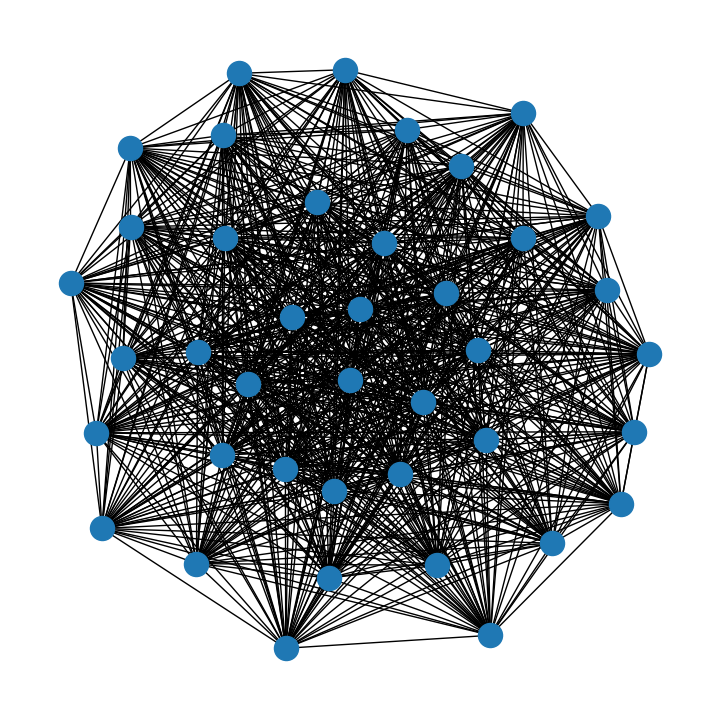

In [10]:
plt.figure(figsize=(7,7))
nx.draw(G)
plt.show()

In [37]:
p = dict(nx.shortest_path_length(G, weight='weight'))
[p[0][i] for i in range(cities.shape[0])]

# p = nx.shortest_path_length(G, source=0, target=13, weight='weight')
# p

[0,
 5.084381891841052,
 10.082311312508343,
 9.523468735599538,
 8.45671409825283,
 10.201078380457686,
 9.515431196029692,
 8.41077279410128,
 9.073704695108631,
 2.934005969962761,
 6.292874994873732,
 3.311090567747432,
 4.972266962951868,
 7.578572954519923,
 9.4322408965485,
 8.801814464245377,
 8.98882424496446,
 6.713688414810149,
 9.5692633303354,
 7.971054189978074,
 10.525259177212796,
 9.628446474848976,
 9.913836546728747,
 9.007501154670782,
 8.901247486911297,
 10.0322859909576,
 3.949384833650373,
 3.8168920682059833,
 5.9060204387690725,
 10.819447756884296,
 3.0287537923634584,
 2.553847896261846,
 12.799021286508829,
 9.766019287571227,
 4.719677654999885,
 9.25960016639896,
 4.706666184600809,
 9.08782941213688,
 3.8917258837585296,
 5.997458437724949]

## Step 2
Define the cost functions
$$C_{tot} = C_{infra} + \gamma C_{trans}$$
$$C_{infra} = \sum_{e_{ij}\in E}d(e_{ij}) $$
$$C_{trans} = \frac{1}{2} \sum_{i,j \in V} P_i P_j ~ \tilde{d}_{ji} $$

Where $ \tilde{d}_{ji}$ is defined by

$$ \tilde{d}(e_{ij}) = (1-\delta) d(e_{ij}) + \delta $$

In [44]:
def C_infra(graph, p= None):
    if p is None:
        p = dict(nx.shortest_path_length(graph, weight='weight'))
    num_nodes = len(graph.nodes)
    sum = 0
    for i in range(num_nodes):
        dist_node = np.sum([p[i][j] for j in range(num_nodes)])
        sum += dist_node
        # print(sum)
    return sum

def eff_len(δ, graph=G, start=0, end=1, d_ij= None):
    if d_ij is None:
        d_ij = nx.shortest_path_length(graph, source=start, target=end, weight='weight')
    eff_d = (1-δ)*d_ij + δ
    return eff_d

def C_trans(graph, δ, Pop=None, p=None):
    if Pop is None:
        Pop = nx.get_node_attributes(graph,name='Population') # dict with population of each node, for ex: {0: 0.234,...}
    if p is None:
        p = dict(nx.shortest_path_length(graph, weight='weight'))
    num_nodes = len(graph.nodes)
    sum = 0
    for i in range(num_nodes):
        for j in range(num_nodes): 
            sum += Pop[i]*Pop[j]*eff_len(δ,d_ij=p[i][j])
    return 0.5*sum

def C_tot(graph,γ,δ,Pop=None,p=None):
    if Pop is None:
        Pop = nx.get_node_attributes(graph,name='Population') # dict with population of each node, for ex: {0: 0.234,...}
    if p is None:
        p = dict(nx.shortest_path_length(graph, weight='weight'))
    return C_infra(graph,p) + γ*C_trans(graph,δ, Pop, p)

In [45]:
C_tot(G,200,0.33)

9332.191451821129